In [2]:
from utils.ifa_meander_project.ifa_meander_utils import *
from utils.ifa_meander_project.ifa_creation_functions import *
from utils.ifa_meander_project.ifa_meander_gmsh import *
from utils.ifa_meander_project.meander_plot import *
from utils.ifa_meander_project.meander_simulation_functions import *

In [2]:
mesh_name = "ifa_meander_2.msh"
save_mesh_folder = 'data/gmsh_files/'
ifa_meander_mat = 'data/antennas_mesh/ifa_meander_2.mat'
ifa_meander_msh = save_mesh_folder + mesh_name

In [3]:
fC      = 868e6
fLow    = 820e6
fHigh   = 940e6

nPoints = calculate_nPoints(fLow, fHigh, fC)
accuracy= 0.01
print(f"nPoints = {nPoints}")

nPoints = 6


In [3]:
# Plages de paramètres à explorer
positions = np.linspace(2.0, 5.0, 4)  # mm
widths    = np.linspace(0.5, 2.0, 4)  # mm
n_meanders = [3, 4, 5]

print(positions)
print(widths)
print(n_meanders)

[2. 3. 4. 5.]
[0.5 1.  1.5 2. ]
[3, 4, 5]


In [4]:
frequencies = np.linspace(fLow, fHigh, nPoints)
print("Liste des frequences : ")
count = 1
for frequency in frequencies:
    print(f"Simulation Numéro {count} = {frequency / 1e6:.2f} MHz")
    count += 1

Liste des frequences : 
Simulation Numéro 1 = 820.00 MHz
Simulation Numéro 2 = 844.00 MHz
Simulation Numéro 3 = 868.00 MHz
Simulation Numéro 4 = 892.00 MHz
Simulation Numéro 5 = 916.00 MHz
Simulation Numéro 6 = 940.00 MHz


In [ ]:
vitesse_lumiere = 3.0e8  # en mètres par seconde (m/s)
longueur_onde = vitesse_lumiere / fC 
quart_d_onde = longueur_onde / 4

print(f"Pour la fréquence de résonance : {fC/1e6:.2f} MHz")
print(f"  - Longueur d'onde (λ)   : {longueur_onde:.4f} m")
print(f"  - Quart d'onde (λ/4)    : {quart_d_onde:.4f} m")

Pour la fréquence de raisonnance 868000000.0 Hz :
Longueur d'onde (λ) = 0.3456221198156682 m
Quart d'onde (λ/4) = 0.08640552995391705 m


In [ ]:
# Dimensions du terminal (en mètres)
terminal_height = 50e-3  # Hauteur du terminal (50 mm)
terminal_width = 30e-3   # Largeur du terminal (30 mm)
antenna_width = 15e-3    # Largeur de l'antenne (15 mm)

# Assignation des variables pour compatibilité avec le reste du notebook
t_a = terminal_height
t_b = terminal_width
a = antenna_width
b = t_b

# Coordonnées du contour du terminal (rectangle centré à l'origine)
x_t = np.array([-t_a, 0, 0, -t_a])
y_t = np.array([t_b/2, t_b/2, -t_b/2, -t_b/2])


# Paramètres de l'antenne IFA meander
wid = 1.0e-3                # Largeur des branches (1 mm)
L_short = 1.15e-3           # Longueur du court-circuit (1.15 mm)
distance_short = t_b / 2    # Distance du court-circuit au bord du terminal

Lenght_antenna = quart_d_onde  # Longueur totale de l'antenne (quart d'onde)

feed_wid = wid              # Largeur du point d'alimentation
feed = t_b/2 - distance_short  # Position du point d'alimentation (centré)
feed_point = [0, feed, 0]   # Coordonnées du point d'alimentation

x, y = ifa_creation_new(Lenght_antenna, a, b, wid, L_short)
x_m, y_m = trace_meander_new(x, y, wid)
feed_x = np.array([0, L_short-wid/2, L_short-wid/2, 0])
feed_y = np.array([feed + feed_wid/2, feed + feed_wid/2, feed -feed_wid/2, feed -feed_wid/2])
antenna_ifa_meander(x_m, y_m, x_t, y_t, feed_x, feed_y, save_mesh_folder, mesh_name, 2.25/1000)

extract_msh_to_mat(ifa_meander_msh, ifa_meander_mat)
s11_db, f_resonance, has_converged = simulate_freq_loop(fLow, fHigh, nPoints, fC, accuracy, ifa_meander_mat, feed_point)
plot_s11_curve(fLow, fHigh, nPoints, s11_db, fC)

In [ ]:
def run_ifa_meander_simulation(iteration, wid, distance_short, x, y, L_short, feed, feed_wid, x_t, y_t, save_mesh_folder, mesh_name, ifa_meander_msh, ifa_meander_mat):
    # Affichage des paramètres de l'itération
    print(f"\n--- Iteration {iteration + 1} ---")
    print(f"Largeur (wid)         : {wid * 1e3:.2f} mm")
    print(f"Distance court-circuit: {distance_short * 1e3:.2f} mm\n")

    # Génération du tracé du méandre
    x_m, y_m = trace_meander_new(x, y, wid)

    # Définition du polygone d'alimentation
    feed_x = np.array([0, L_short - wid / 2, L_short - wid / 2, 0])
    feed_y = np.array([
        feed + feed_wid / 2,
        feed + feed_wid / 2,
        feed - feed_wid / 2,
        feed - feed_wid / 2
    ])

    # Création de l'antenne et extraction du maillage
    antenna_ifa_meander(x_m, y_m, x_t, y_t, feed_x, feed_y, save_mesh_folder, mesh_name, 2.25e-3)
    extract_msh_to_mat(ifa_meander_msh, ifa_meander_mat)


def update_ifa_meander_params(new_distance_short, new_wid, new_Nombre_meandre, t_b):
    distance_short = float(new_distance_short)
    wid = float(new_wid)
    feed = t_b / 2 - distance_short
    feed_wid = wid
    feed_point = [0, feed, 0]

    # Retourne toujours les mêmes paramètres, new_Nombre_meandre peut être None
    return distance_short, wid, new_Nombre_meandre, feed, feed_wid, feed_point


Number of meanders 2
distance meandres 0.006925

Iteration 1

wid = 1.0
short feed = 15.0

Simulation 1/11 | f = 820.00 MHz | S11 = -0.10 dB
Simulation 2/11 | f = 832.00 MHz | S11 = -0.12 dB
Simulation 3/11 | f = 844.00 MHz | S11 = -0.13 dB
Simulation 4/11 | f = 856.00 MHz | S11 = -0.15 dB


Simulation 5/11 | f = 868.00 MHz | S11 = -0.18 dB
Simulation 6/11 | f = 880.00 MHz | S11 = -0.21 dB
Simulation 7/11 | f = 892.00 MHz | S11 = -0.24 dB
Simulation 8/11 | f = 904.00 MHz | S11 = -0.28 dB
Simulation 9/11 | f = 916.00 MHz | S11 = -0.33 dB
Simulation 10/11 | f = 928.00 MHz | S11 = -0.38 dB
Simulation 11/11 | f = 940.00 MHz | S11 = -0.45 dB

📡 Résultats de simulation :
→ Fréquence de résonance = 940.00 MHz
→ Impédance à f_res      = 8.97+121.39j Ω

❌ Pas de convergence —> Réajustement couplé intelligent...

📉 f trop haute —> + méandres

📐 Paramètres ajustés intelligemment :
• Distance short-feed : 12.97 mm
• Largeur de trace    : 1.20 mm
• Nombre de méandres  : 3



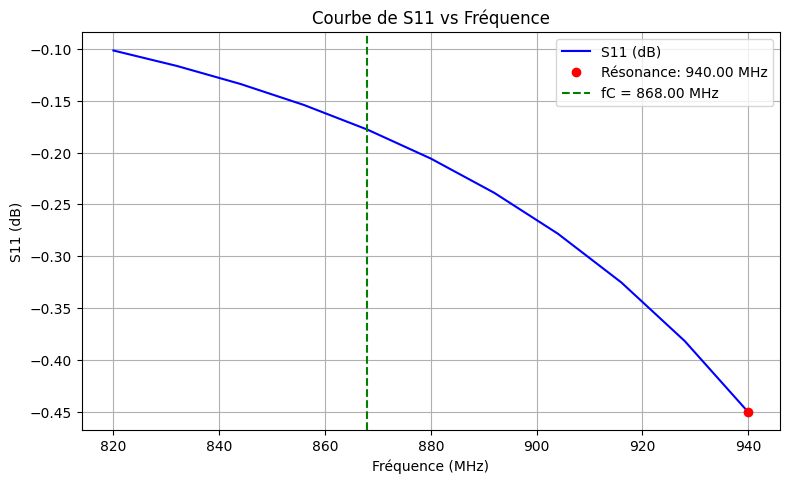

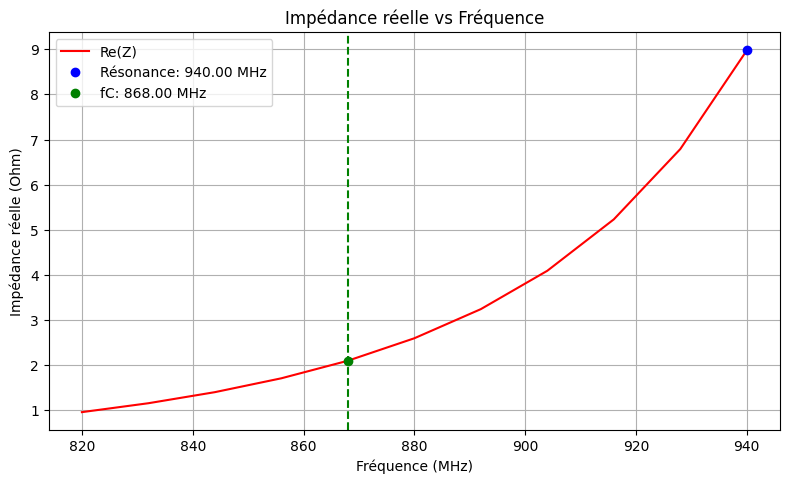

Number of meanders 3
distance meandres 0.0046166666666666665

Iteration 2

wid = 1.2
short feed = 12.972679967220145

Simulation 1/11 | f = 820.00 MHz | S11 = -0.15 dB
Simulation 2/11 | f = 832.00 MHz | S11 = -0.18 dB
Simulation 3/11 | f = 844.00 MHz | S11 = -0.21 dB
Simulation 4/11 | f = 856.00 MHz | S11 = -0.26 dB


Simulation 5/11 | f = 868.00 MHz | S11 = -0.32 dB
Simulation 6/11 | f = 880.00 MHz | S11 = -0.39 dB
Simulation 7/11 | f = 892.00 MHz | S11 = -0.49 dB
Simulation 8/11 | f = 904.00 MHz | S11 = -0.62 dB
Simulation 9/11 | f = 916.00 MHz | S11 = -0.79 dB
Simulation 10/11 | f = 928.00 MHz | S11 = -1.04 dB
Simulation 11/11 | f = 940.00 MHz | S11 = -1.38 dB

📡 Résultats de simulation :
→ Fréquence de résonance = 940.00 MHz
→ Impédance à f_res      = 31.47+128.43j Ω

❌ Pas de convergence —> Réajustement couplé intelligent...

📉 f trop haute —> + méandres

📐 Paramètres ajustés intelligemment :
• Distance short-feed : 11.22 mm
• Largeur de trace    : 1.33 mm
• Nombre de méandres  : 4



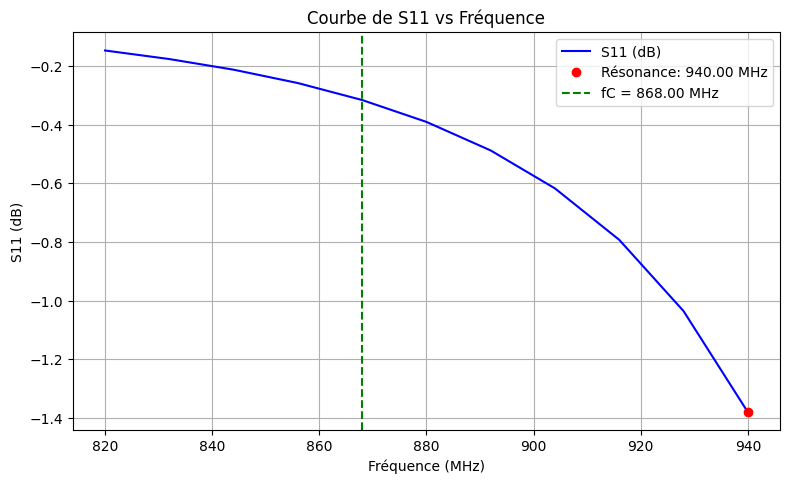

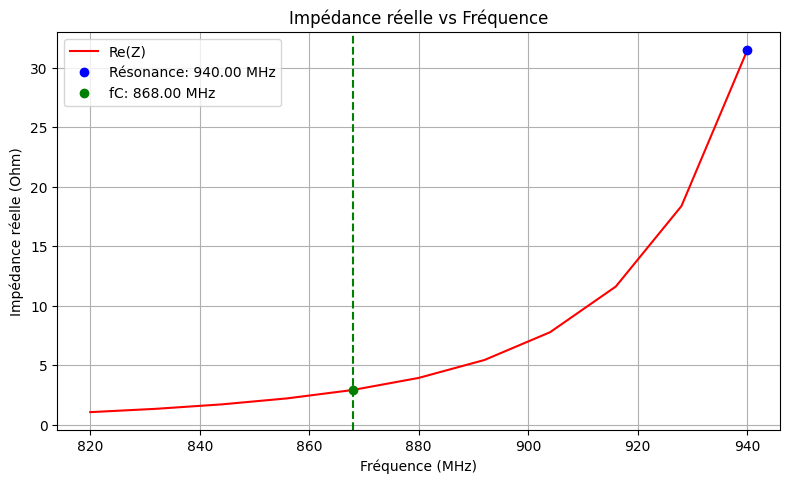

Number of meanders 4
distance meandres 0.0034625

Iteration 3

wid = 1.3333909198197207
short feed = 11.219361702127658

Simulation 1/11 | f = 820.00 MHz | S11 = -0.17 dB
Simulation 2/11 | f = 832.00 MHz | S11 = -0.21 dB
Simulation 3/11 | f = 844.00 MHz | S11 = -0.26 dB
Simulation 4/11 | f = 856.00 MHz | S11 = -0.33 dB


Simulation 5/11 | f = 868.00 MHz | S11 = -0.43 dB
Simulation 6/11 | f = 880.00 MHz | S11 = -0.58 dB
Simulation 7/11 | f = 892.00 MHz | S11 = -0.79 dB
Simulation 8/11 | f = 904.00 MHz | S11 = -1.11 dB
Simulation 9/11 | f = 916.00 MHz | S11 = -1.62 dB
Simulation 10/11 | f = 928.00 MHz | S11 = -2.49 dB
Simulation 11/11 | f = 940.00 MHz | S11 = -4.06 dB

📡 Résultats de simulation :
→ Fréquence de résonance = 940.00 MHz
→ Impédance à f_res      = 96.77+101.72j Ω

❌ Pas de convergence —> Réajustement couplé intelligent...

📉 f trop haute —> + méandres

📐 Paramètres ajustés intelligemment :
• Distance short-feed : 9.70 mm
• Largeur de trace    : 1.07 mm
• Nombre de méandres  : 5



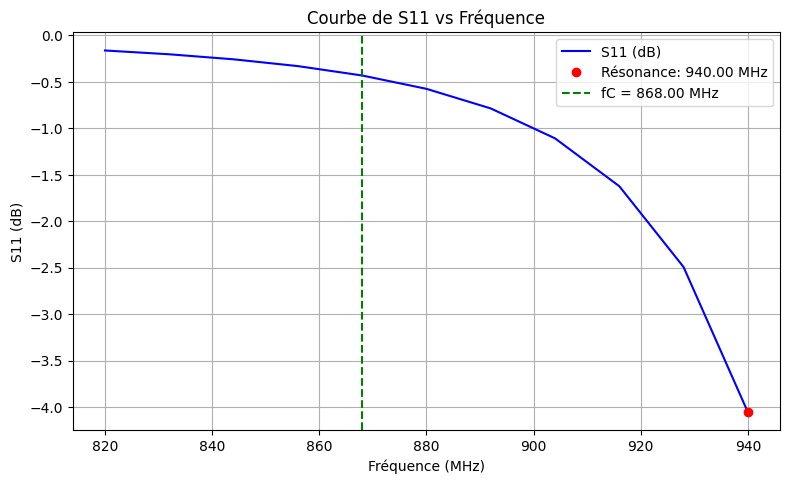

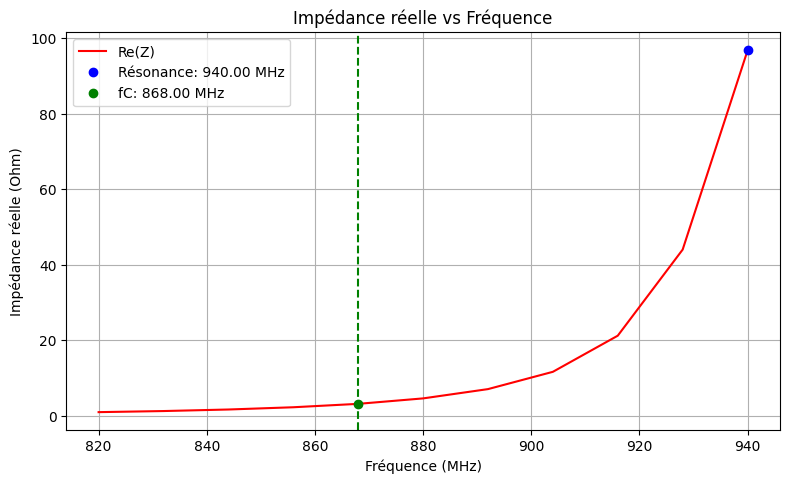

Number of meanders 5
distance meandres 0.00277

Iteration 4

wid = 1.0667127358557766
short feed = 9.703012586545894

Simulation 1/11 | f = 820.00 MHz | S11 = -0.52 dB
Simulation 2/11 | f = 832.00 MHz | S11 = -0.78 dB
Simulation 3/11 | f = 844.00 MHz | S11 = -1.27 dB
Simulation 4/11 | f = 856.00 MHz | S11 = -2.26 dB


Simulation 5/11 | f = 868.00 MHz | S11 = -4.56 dB
Simulation 6/11 | f = 880.00 MHz | S11 = -10.73 dB
Simulation 7/11 | f = 892.00 MHz | S11 = -12.72 dB
Simulation 8/11 | f = 904.00 MHz | S11 = -5.65 dB
Simulation 9/11 | f = 916.00 MHz | S11 = -3.02 dB
Simulation 10/11 | f = 928.00 MHz | S11 = -1.85 dB
Simulation 11/11 | f = 940.00 MHz | S11 = -1.25 dB

📡 Résultats de simulation :
→ Fréquence de résonance = 892.00 MHz
→ Impédance à f_res      = 33.93-11.18j Ω

❌ Pas de convergence —> Réajustement couplé intelligent...


📐 Paramètres ajustés intelligemment :
• Distance short-feed : 10.00 mm
• Largeur de trace    : 1.17 mm
• Nombre de méandres  : 5



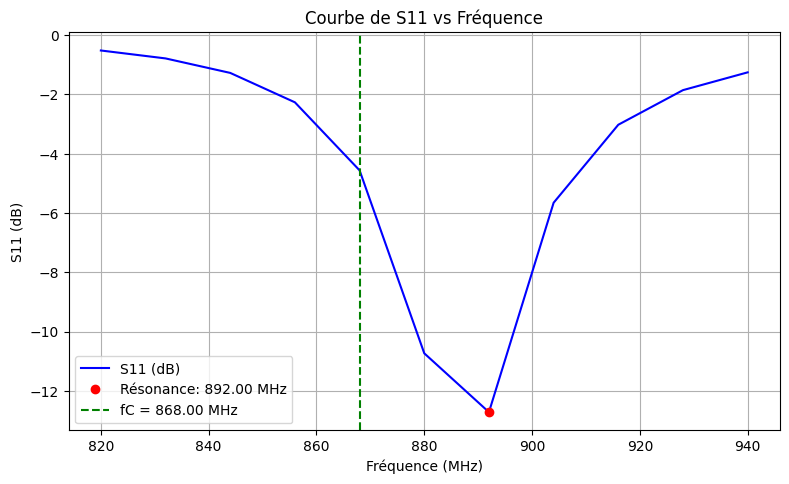

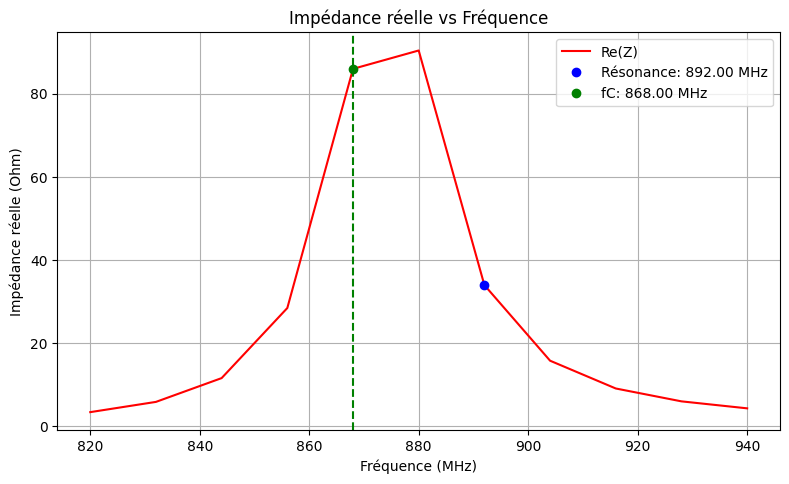

Number of meanders 5
distance meandres 0.00277

Iteration 5

wid = 1.1695590775006235
short feed = 9.999794294309815

Simulation 1/11 | f = 820.00 MHz | S11 = -0.33 dB
Simulation 2/11 | f = 832.00 MHz | S11 = -0.46 dB
Simulation 3/11 | f = 844.00 MHz | S11 = -0.66 dB
Simulation 4/11 | f = 856.00 MHz | S11 = -1.02 dB


Simulation 5/11 | f = 868.00 MHz | S11 = -1.66 dB
Simulation 6/11 | f = 880.00 MHz | S11 = -2.98 dB
Simulation 7/11 | f = 892.00 MHz | S11 = -6.02 dB
Simulation 8/11 | f = 904.00 MHz | S11 = -14.07 dB
Simulation 9/11 | f = 916.00 MHz | S11 = -11.14 dB
Simulation 10/11 | f = 928.00 MHz | S11 = -5.32 dB
Simulation 11/11 | f = 940.00 MHz | S11 = -3.01 dB

📡 Résultats de simulation :
→ Fréquence de résonance = 904.00 MHz
→ Impédance à f_res      = 69.77-13.36j Ω

❌ Pas de convergence —> Réajustement couplé intelligent...


📐 Paramètres ajustés intelligemment :
• Distance short-feed : 10.32 mm
• Largeur de trace    : 1.03 mm
• Nombre de méandres  : 5



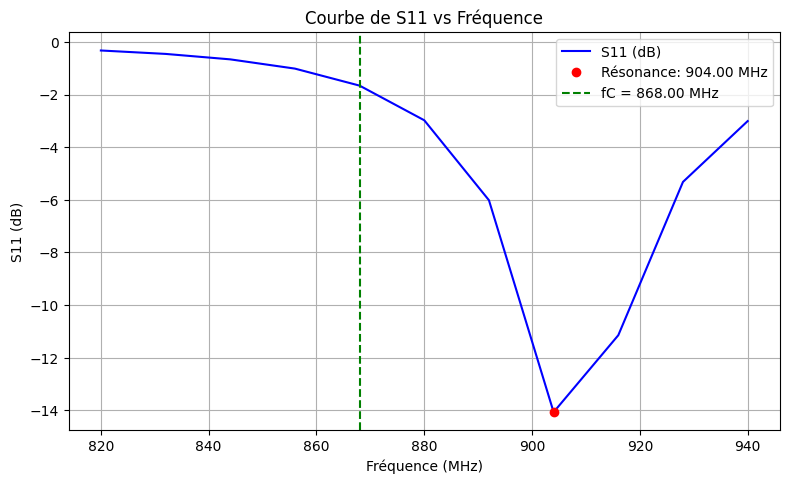

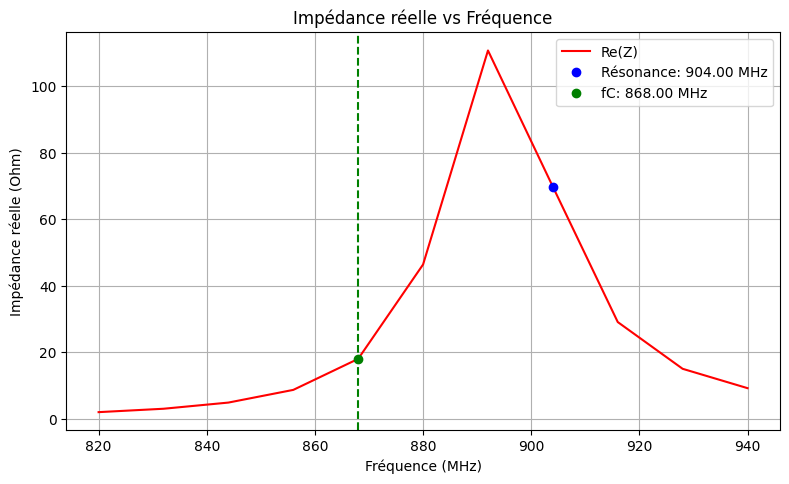

Number of meanders 5
distance meandres 0.00277

Iteration 6

wid = 1.0308468037769936
short feed = 10.322493429329219

Simulation 1/11 | f = 820.00 MHz | S11 = -0.63 dB
Simulation 2/11 | f = 832.00 MHz | S11 = -0.98 dB
Simulation 3/11 | f = 844.00 MHz | S11 = -1.62 dB
Simulation 4/11 | f = 856.00 MHz | S11 = -2.97 dB


Simulation 5/11 | f = 868.00 MHz | S11 = -6.14 dB
Simulation 6/11 | f = 880.00 MHz | S11 = -13.09 dB
Simulation 7/11 | f = 892.00 MHz | S11 = -8.87 dB
Simulation 8/11 | f = 904.00 MHz | S11 = -4.43 dB
Simulation 9/11 | f = 916.00 MHz | S11 = -2.55 dB
Simulation 10/11 | f = 928.00 MHz | S11 = -1.64 dB
Simulation 11/11 | f = 940.00 MHz | S11 = -1.14 dB

📡 Résultats de simulation :
→ Fréquence de résonance = 880.00 MHz
→ Impédance à f_res      = 59.56-22.87j Ω

❌ Pas de convergence —> Réajustement couplé intelligent...


📐 Paramètres ajustés intelligemment :
• Distance short-feed : 11.19 mm
• Largeur de trace    : 0.97 mm
• Nombre de méandres  : 5



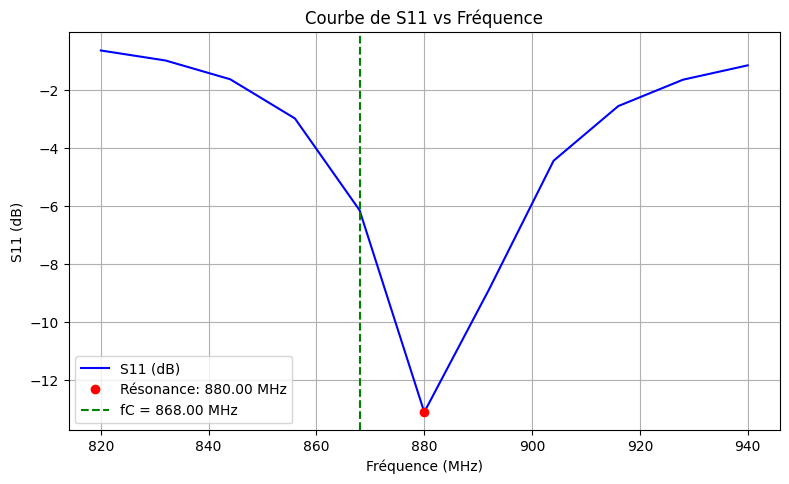

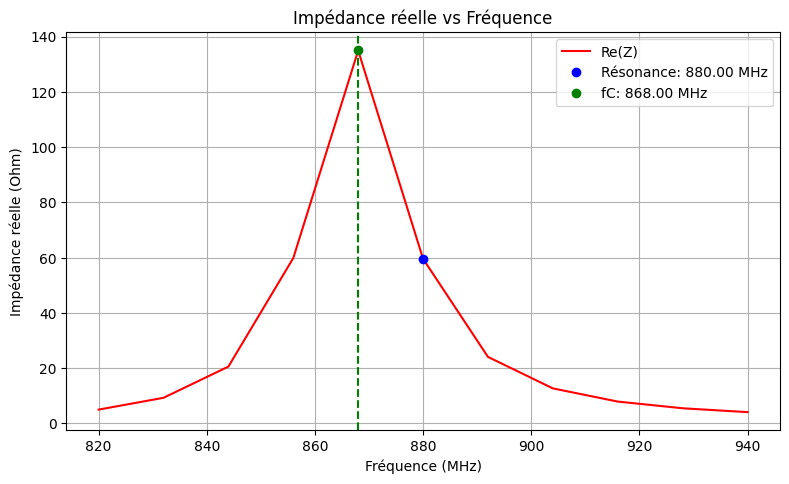

Number of meanders 5
distance meandres 0.00277

Iteration 7

wid = 0.9716996722240356
short feed = 11.189624312264014

Simulation 1/11 | f = 820.00 MHz | S11 = -0.84 dB
Simulation 2/11 | f = 832.00 MHz | S11 = -1.35 dB
Simulation 3/11 | f = 844.00 MHz | S11 = -2.36 dB
Simulation 4/11 | f = 856.00 MHz | S11 = -4.58 dB


Simulation 5/11 | f = 868.00 MHz | S11 = -9.52 dB
Simulation 6/11 | f = 880.00 MHz | S11 = -10.54 dB
Simulation 7/11 | f = 892.00 MHz | S11 = -5.46 dB
Simulation 8/11 | f = 904.00 MHz | S11 = -3.05 dB
Simulation 9/11 | f = 916.00 MHz | S11 = -1.90 dB
Simulation 10/11 | f = 928.00 MHz | S11 = -1.30 dB
Simulation 11/11 | f = 940.00 MHz | S11 = -0.94 dB

📡 Résultats de simulation :
→ Fréquence de résonance = 880.00 MHz
→ Impédance à f_res      = 30.58-14.65j Ω

❌ Pas de convergence —> Réajustement couplé intelligent...


📐 Paramètres ajustés intelligemment :
• Distance short-feed : 11.76 mm
• Largeur de trace    : 1.08 mm
• Nombre de méandres  : 5



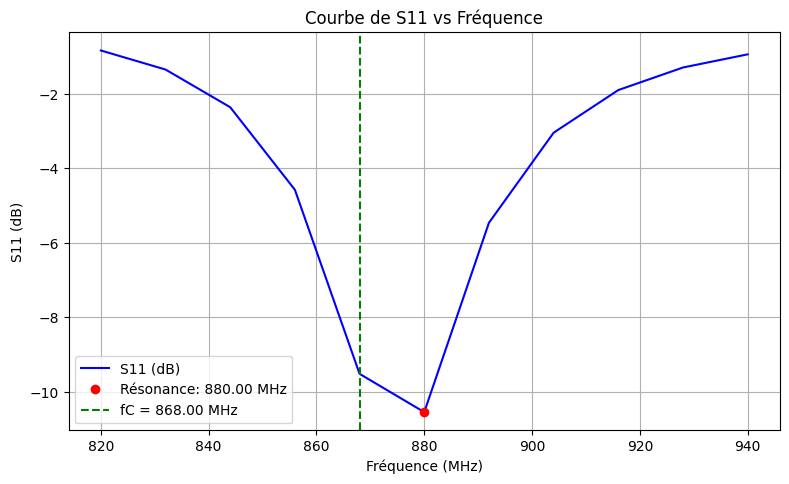

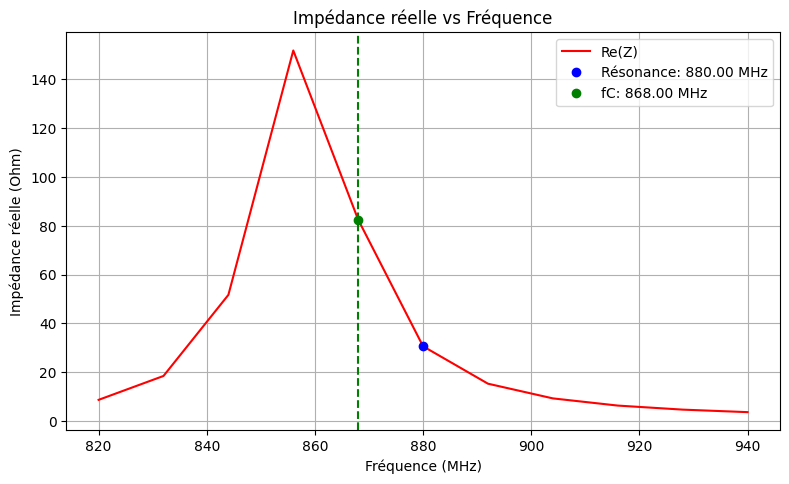

Number of meanders 5
distance meandres 0.00277

Iteration 8

wid = 1.084909514779575
short feed = 11.764506149664765

Simulation 1/11 | f = 820.00 MHz | S11 = -0.50 dB
Simulation 2/11 | f = 832.00 MHz | S11 = -0.72 dB
Simulation 3/11 | f = 844.00 MHz | S11 = -1.08 dB
Simulation 4/11 | f = 856.00 MHz | S11 = -1.75 dB


Simulation 5/11 | f = 868.00 MHz | S11 = -3.05 dB
Simulation 6/11 | f = 880.00 MHz | S11 = -5.85 dB
Simulation 7/11 | f = 892.00 MHz | S11 = -11.41 dB
Simulation 8/11 | f = 904.00 MHz | S11 = -9.92 dB
Simulation 9/11 | f = 916.00 MHz | S11 = -5.30 dB
Simulation 10/11 | f = 928.00 MHz | S11 = -3.10 dB
Simulation 11/11 | f = 940.00 MHz | S11 = -2.01 dB

📡 Résultats de simulation :
→ Fréquence de résonance = 892.00 MHz
→ Impédance à f_res      = 62.91-28.54j Ω

❌ Pas de convergence —> Réajustement couplé intelligent...


📐 Paramètres ajustés intelligemment :
• Distance short-feed : 12.77 mm
• Largeur de trace    : 1.00 mm
• Nombre de méandres  : 5



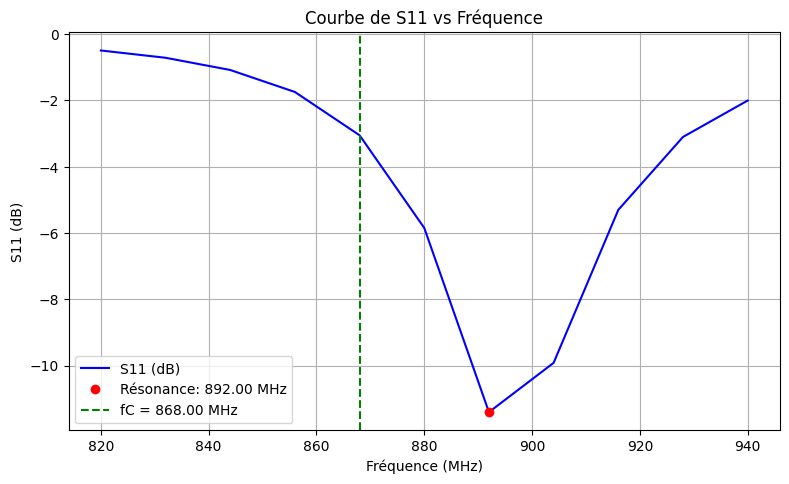

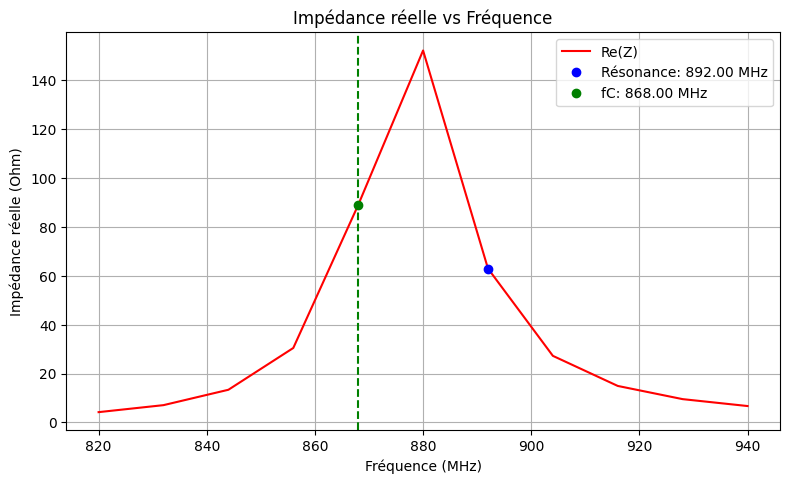

Number of meanders 5
distance meandres 0.00277

Iteration 9

wid = 1.0008842629812855
short feed = 12.765676118941832

Simulation 1/11 | f = 820.00 MHz | S11 = -0.73 dB
Simulation 2/11 | f = 832.00 MHz | S11 = -1.09 dB
Simulation 3/11 | f = 844.00 MHz | S11 = -1.75 dB
Simulation 4/11 | f = 856.00 MHz | S11 = -3.02 dB


Simulation 5/11 | f = 868.00 MHz | S11 = -5.61 dB
Simulation 6/11 | f = 880.00 MHz | S11 = -9.95 dB
Simulation 7/11 | f = 892.00 MHz | S11 = -8.82 dB
Simulation 8/11 | f = 904.00 MHz | S11 = -5.03 dB
Simulation 9/11 | f = 916.00 MHz | S11 = -3.01 dB
Simulation 10/11 | f = 928.00 MHz | S11 = -1.97 dB
Simulation 11/11 | f = 940.00 MHz | S11 = -1.38 dB

📡 Résultats de simulation :
→ Fréquence de résonance = 880.00 MHz
→ Impédance à f_res      = 53.90-34.62j Ω

❌ Pas de convergence —> Réajustement couplé intelligent...


📐 Paramètres ajustés intelligemment :
• Distance short-feed : 13.95 mm
• Largeur de trace    : 0.98 mm
• Nombre de méandres  : 5



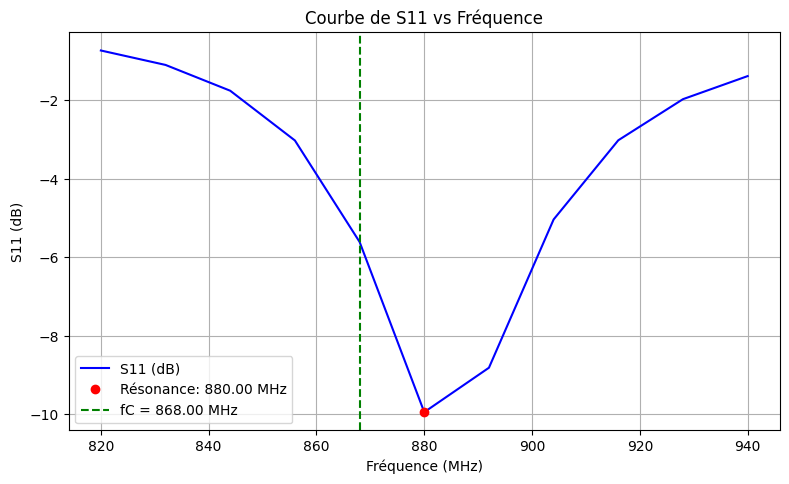

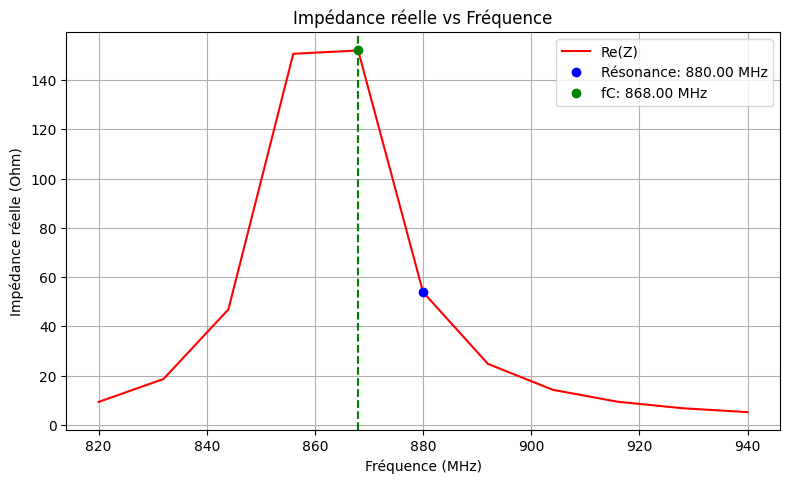

Number of meanders 5
distance meandres 0.00277

Iteration 10

wid = 0.977474638646164
short feed = 13.946172520245009

Simulation 1/11 | f = 820.00 MHz | S11 = -0.79 dB
Simulation 2/11 | f = 832.00 MHz | S11 = -1.19 dB
Simulation 3/11 | f = 844.00 MHz | S11 = -1.90 dB
Simulation 4/11 | f = 856.00 MHz | S11 = -3.26 dB


Simulation 5/11 | f = 868.00 MHz | S11 = -5.89 dB
Simulation 6/11 | f = 880.00 MHz | S11 = -9.56 dB
Simulation 7/11 | f = 892.00 MHz | S11 = -7.98 dB
Simulation 8/11 | f = 904.00 MHz | S11 = -4.73 dB
Simulation 9/11 | f = 916.00 MHz | S11 = -2.91 dB
Simulation 10/11 | f = 928.00 MHz | S11 = -1.93 dB
Simulation 11/11 | f = 940.00 MHz | S11 = -1.37 dB

📡 Résultats de simulation :
→ Fréquence de résonance = 880.00 MHz
→ Impédance à f_res      = 44.30-32.72j Ω

❌ Pas de convergence —> Réajustement couplé intelligent...


📐 Paramètres ajustés intelligemment :
• Distance short-feed : 15.24 mm
• Largeur de trace    : 1.01 mm
• Nombre de méandres  : 5



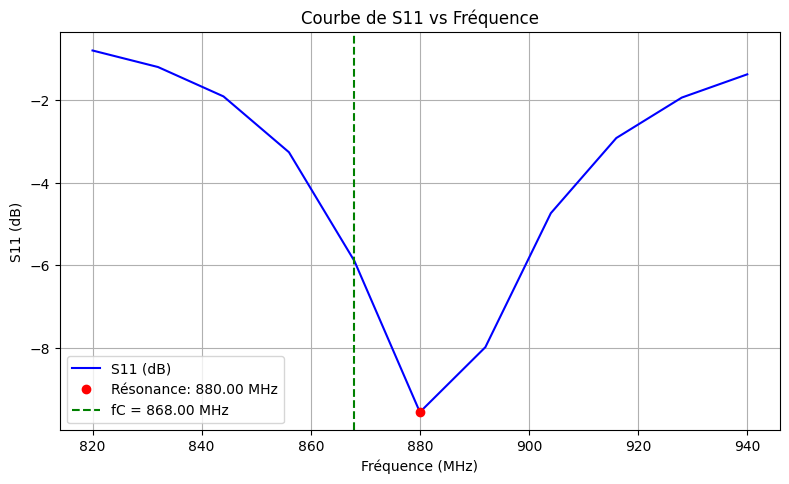

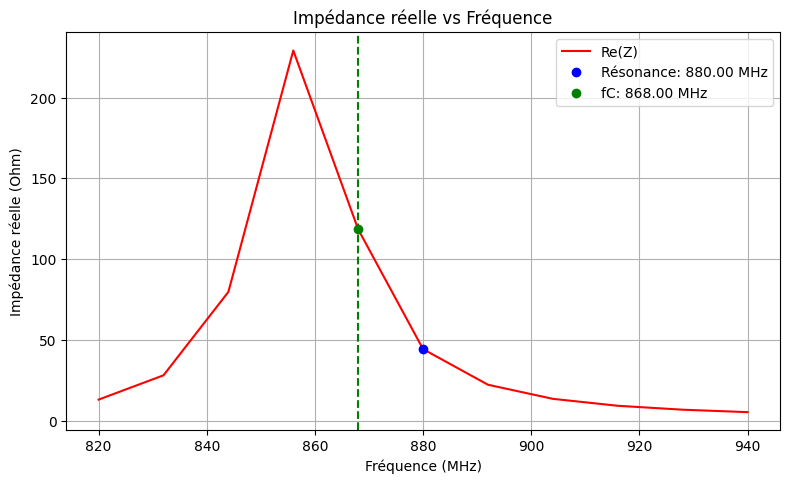

Number of meanders 5
distance meandres 0.00277

Iteration 11

wid = 1.0108789614484774
short feed = 15.23583444795708

Simulation 1/11 | f = 820.00 MHz | S11 = -0.63 dB
Simulation 2/11 | f = 832.00 MHz | S11 = -0.91 dB
Simulation 3/11 | f = 844.00 MHz | S11 = -1.36 dB
Simulation 4/11 | f = 856.00 MHz | S11 = -2.15 dB


Simulation 5/11 | f = 868.00 MHz | S11 = -3.60 dB
Simulation 6/11 | f = 880.00 MHz | S11 = -6.29 dB
Simulation 7/11 | f = 892.00 MHz | S11 = -9.51 dB
Simulation 8/11 | f = 904.00 MHz | S11 = -7.83 dB
Simulation 9/11 | f = 916.00 MHz | S11 = -4.81 dB
Simulation 10/11 | f = 928.00 MHz | S11 = -3.04 dB
Simulation 11/11 | f = 940.00 MHz | S11 = -2.04 dB

📡 Résultats de simulation :
→ Fréquence de résonance = 892.00 MHz
→ Impédance à f_res      = 39.00-29.36j Ω

❌ Pas de convergence —> Réajustement couplé intelligent...


📐 Paramètres ajustés intelligemment :
• Distance short-feed : 16.53 mm
• Largeur de trace    : 1.08 mm
• Nombre de méandres  : 5



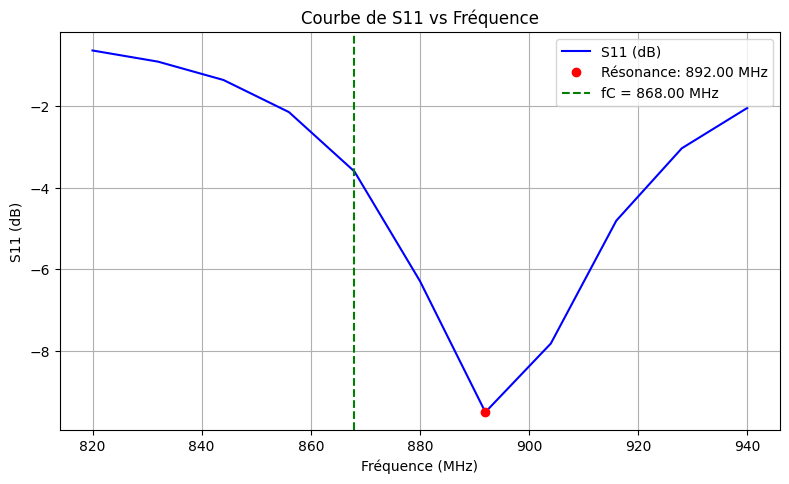

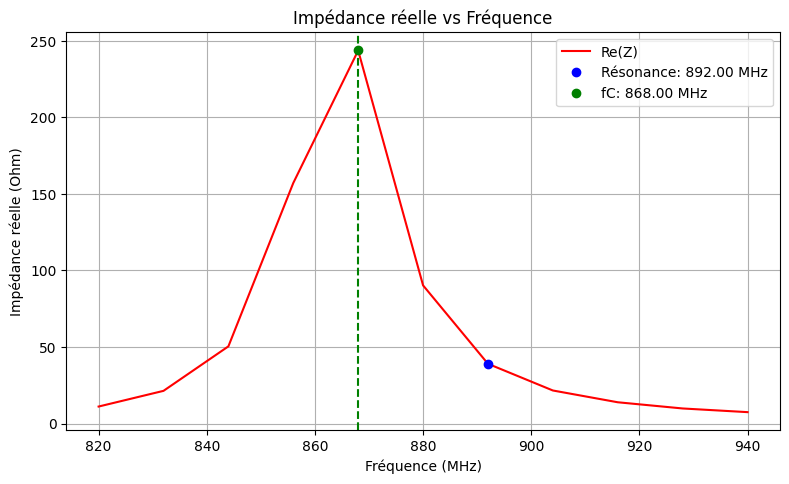

Number of meanders 5
distance meandres 0.00277

Iteration 12

wid = 1.0775929835387998
short feed = 16.53241755243413

Simulation 1/11 | f = 820.00 MHz | S11 = -0.48 dB
Simulation 2/11 | f = 832.00 MHz | S11 = -0.65 dB
Simulation 3/11 | f = 844.00 MHz | S11 = -0.91 dB
Simulation 4/11 | f = 856.00 MHz | S11 = -1.33 dB


Simulation 5/11 | f = 868.00 MHz | S11 = -2.02 dB
Simulation 6/11 | f = 880.00 MHz | S11 = -3.25 dB
Simulation 7/11 | f = 892.00 MHz | S11 = -5.43 dB
Simulation 8/11 | f = 904.00 MHz | S11 = -8.66 dB
Simulation 9/11 | f = 916.00 MHz | S11 = -9.11 dB
Simulation 10/11 | f = 928.00 MHz | S11 = -6.11 dB
Simulation 11/11 | f = 940.00 MHz | S11 = -3.89 dB

📡 Résultats de simulation :
→ Fréquence de résonance = 916.00 MHz
→ Impédance à f_res      = 26.22-12.93j Ω

❌ Pas de convergence —> Réajustement couplé intelligent...


📐 Paramètres ajustés intelligemment :
• Distance short-feed : 16.93 mm
• Largeur de trace    : 1.23 mm
• Nombre de méandres  : 5



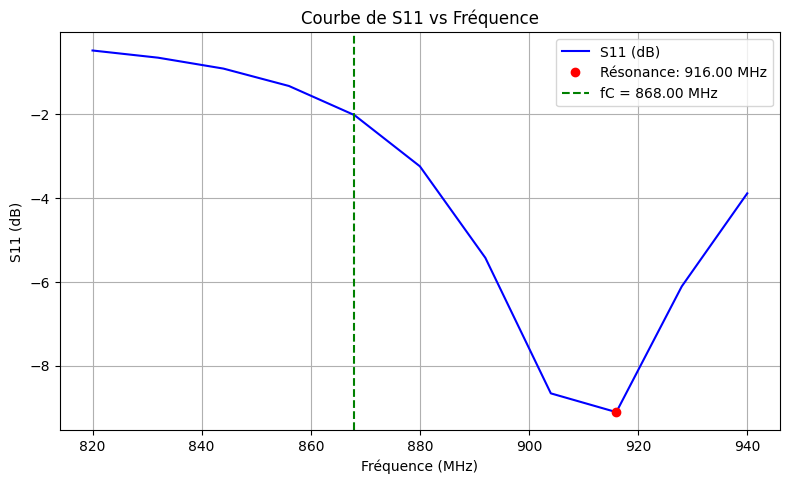

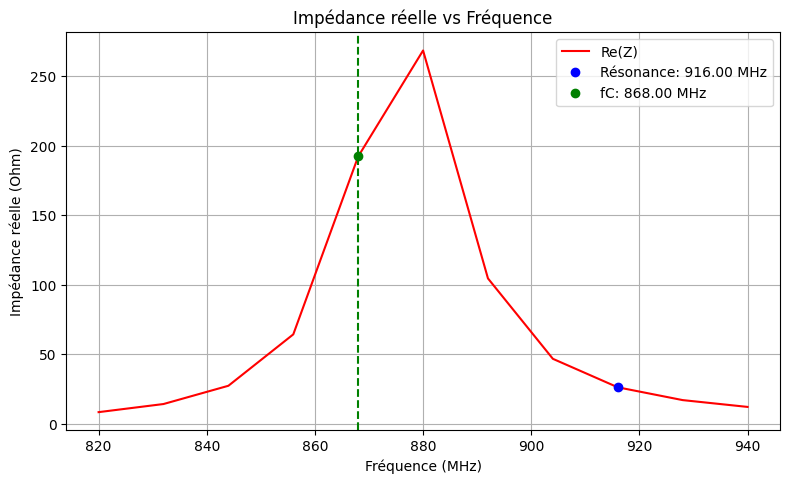

Number of meanders 5
distance meandres 0.00277

Iteration 13

wid = 1.2313740144886356
short feed = 16.92605437538278

Simulation 1/11 | f = 820.00 MHz | S11 = -0.29 dB
Simulation 2/11 | f = 832.00 MHz | S11 = -0.37 dB
Simulation 3/11 | f = 844.00 MHz | S11 = -0.48 dB
Simulation 4/11 | f = 856.00 MHz | S11 = -0.64 dB


Simulation 5/11 | f = 868.00 MHz | S11 = -0.88 dB
Simulation 6/11 | f = 880.00 MHz | S11 = -1.23 dB
Simulation 7/11 | f = 892.00 MHz | S11 = -1.81 dB
Simulation 8/11 | f = 904.00 MHz | S11 = -2.77 dB
Simulation 9/11 | f = 916.00 MHz | S11 = -4.47 dB
Simulation 10/11 | f = 928.00 MHz | S11 = -7.43 dB
Simulation 11/11 | f = 940.00 MHz | S11 = -10.91 dB

📡 Résultats de simulation :
→ Fréquence de résonance = 940.00 MHz
→ Impédance à f_res      = 39.66-24.36j Ω

❌ Pas de convergence —> Réajustement couplé intelligent...

📉 f trop haute —> + méandres

📐 Paramètres ajustés intelligemment :
• Distance short-feed : 17.85 mm
• Largeur de trace    : 1.31 mm
• Nombre de méandres  : 5



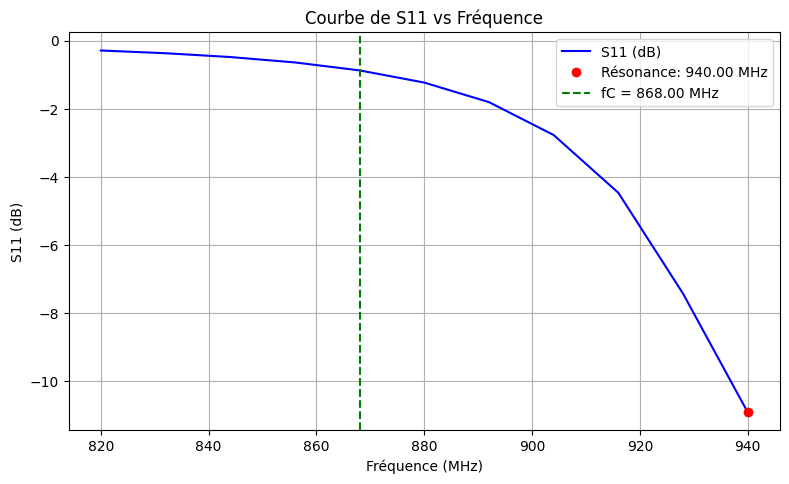

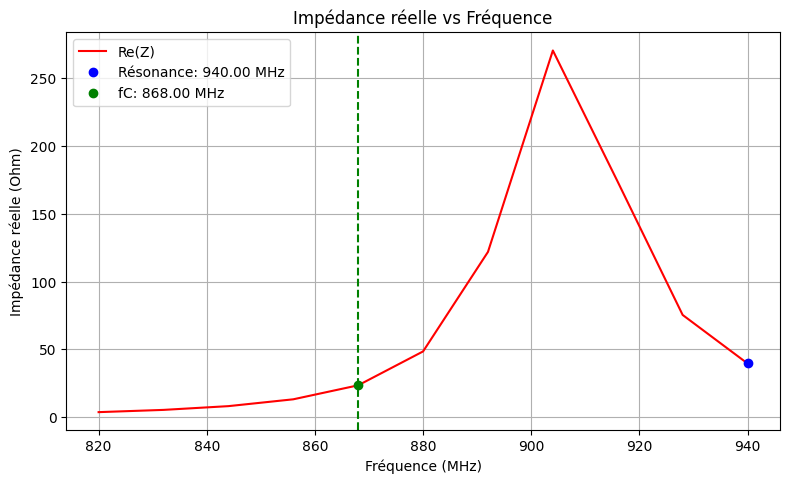

Number of meanders 5
distance meandres 0.00277

Iteration 14

wid = 1.3077610113465987
short feed = 17.849457241435818

Simulation 1/11 | f = 820.00 MHz | S11 = -0.24 dB
Simulation 2/11 | f = 832.00 MHz | S11 = -0.30 dB
Simulation 3/11 | f = 844.00 MHz | S11 = -0.38 dB
Simulation 4/11 | f = 856.00 MHz | S11 = -0.48 dB


Simulation 5/11 | f = 868.00 MHz | S11 = -0.63 dB
Simulation 6/11 | f = 880.00 MHz | S11 = -0.85 dB
Simulation 7/11 | f = 892.00 MHz | S11 = -1.16 dB
Simulation 8/11 | f = 904.00 MHz | S11 = -1.66 dB
Simulation 9/11 | f = 916.00 MHz | S11 = -2.46 dB
Simulation 10/11 | f = 928.00 MHz | S11 = -3.81 dB
Simulation 11/11 | f = 940.00 MHz | S11 = -6.15 dB

📡 Résultats de simulation :
→ Fréquence de résonance = 940.00 MHz
→ Impédance à f_res      = 100.62-62.31j Ω

❌ Pas de convergence —> Réajustement couplé intelligent...

📉 f trop haute —> + méandres

📐 Paramètres ajustés intelligemment :
• Distance short-feed : 18.87 mm
• Largeur de trace    : 1.05 mm
• Nombre de méandres  : 5



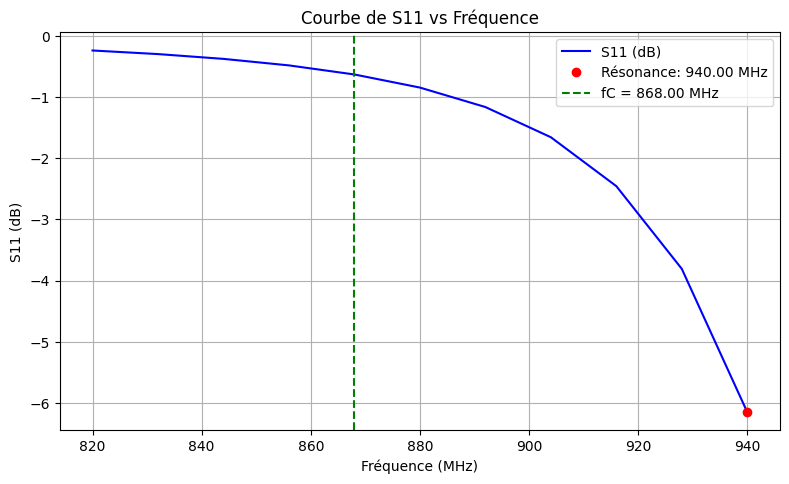

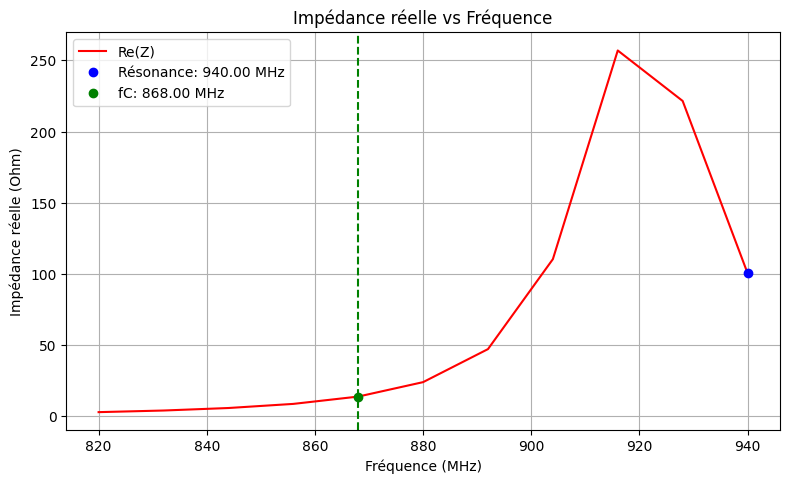

Number of meanders 5
distance meandres 0.00277

Iteration 15

wid = 1.046208809077279
short feed = 18.867468594066647

Simulation 1/11 | f = 820.00 MHz | S11 = -0.50 dB
Simulation 2/11 | f = 832.00 MHz | S11 = -0.67 dB
Simulation 3/11 | f = 844.00 MHz | S11 = -0.92 dB
Simulation 4/11 | f = 856.00 MHz | S11 = -1.33 dB


Simulation 5/11 | f = 868.00 MHz | S11 = -1.99 dB
Simulation 6/11 | f = 880.00 MHz | S11 = -3.13 dB
Simulation 7/11 | f = 892.00 MHz | S11 = -5.09 dB
Simulation 8/11 | f = 904.00 MHz | S11 = -7.96 dB
Simulation 9/11 | f = 916.00 MHz | S11 = -8.84 dB
Simulation 10/11 | f = 928.00 MHz | S11 = -6.31 dB
Simulation 11/11 | f = 940.00 MHz | S11 = -4.09 dB

📡 Résultats de simulation :
→ Fréquence de résonance = 916.00 MHz
→ Impédance à f_res      = 25.72-13.53j Ω

❌ Pas de convergence —> Réajustement couplé intelligent...


📐 Paramètres ajustés intelligemment :
• Distance short-feed : 19.36 mm
• Largeur de trace    : 1.20 mm
• Nombre de méandres  : 5



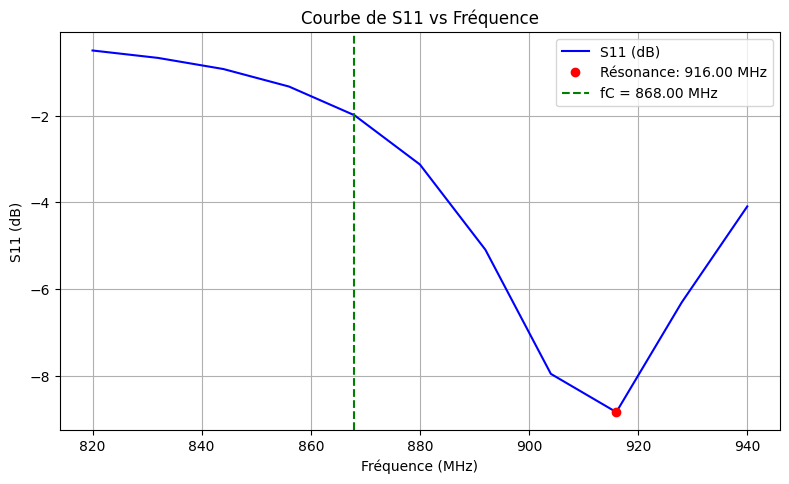

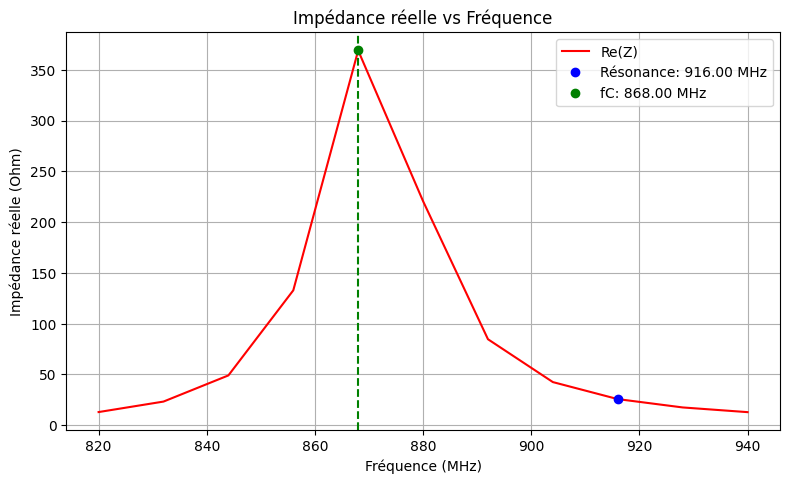

Number of meanders 5
distance meandres 0.00277


In [9]:
has_converged = False
max_iterations = 15

x, y, Nombre_meandre = ifa_creation_new(Lenght_antenna, a, b, wid, L_short)

# Nombre_meandre = 6

# Loop for simulation
iteration = 0
while not has_converged and iteration < max_iterations:

    run_ifa_meander_simulation(iteration, wid, distance_short, x, y, L_short, feed, feed_wid, x_t, y_t, save_mesh_folder, mesh_name, ifa_meander_msh, ifa_meander_mat)

    s11_db, f_resonance, new_distance_short, new_wid, new_Nombre_meandre, has_converged, impedances = simulate_freq_loop_test_version_2(
        fLow, fHigh, nPoints, fC, accuracy, ifa_meander_mat, feed_point, distance_short, wid, Lenght_antenna, b, a, L_short, Nombre_meandre)
    
    # Remplacement par appel de la fonction update_ifa_meander_params
    distance_short, wid, Nombre_meandre, feed, feed_wid, feed_point = update_ifa_meander_params(new_distance_short, new_wid, new_Nombre_meandre, t_b)

    plot_s11_curve(fLow, fHigh, nPoints, s11_db, fC)
    plot_impedance(fLow, fHigh, nPoints, impedances, s11_db, fC)

    x, y = ifa_creation_optimisation(Lenght_antenna, a, b, wid, Nombre_meandre, L_short)
    iteration += 1

    """ if has_converged:
        iteration_optimised = iteration - 1
        print(f"On est dans la plage de convergence")
        # appel de la fonction qui met à jour les paramètres
        has_optimised = False
        while not has_optimised:

            run_ifa_meander_simulation(iteration_optimised, wid, distance_short, x, y, L_short, feed, feed_wid, x_t, y_t, save_mesh_folder, mesh_name, ifa_meander_msh, ifa_meander_mat)

            s11_db, f_resonance, new_distance_short, new_wid, has_optimised, impedances = loop_in_interval(
            fLow, fHigh, nPoints, fC, accuracy, ifa_meander_mat, feed_point, distance_short, wid, b)

            distance_short, wid, feed, feed_wid, feed_point = update_ifa_meander_params(new_distance_short, new_wid, None, t_b)

            plot_s11_curve(fLow, fHigh, nPoints, s11_db, fC)
            plot_impedance(fLow, fHigh, nPoints, impedances, s11_db, fC)
            x, y = ifa_creation_optimisation(Lenght_antenna, a, b, wid, Nombre_meandre, L_short)
            iteration_optimised += 1 """


